In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [3]:
mnist = fetch_openml('mnist_784')
X, y = np.array(mnist['data'], dtype=float), np.array(mnist['target'], dtype=float)
print('fetched!')

fetched!


## Task 1

In [4]:
train_size = 60000
shuffle_index = np.random.permutation(train_size)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [26]:
param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [2, 3, 4, 5]}]
kn_cls = KNeighborsClassifier()
grid_search = GridSearchCV(kn_cls, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print('competed!')

competed!


In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
print(grid_search.best_estimator_)

0.8170373308484747 {'n_neighbors': 2, 'weights': 'uniform'}
0.7333371212023385 {'n_neighbors': 2, 'weights': 'distance'}
0.7640462464188059 {'n_neighbors': 3, 'weights': 'uniform'}
0.7303880247284088 {'n_neighbors': 3, 'weights': 'distance'}
0.7676587783644502 {'n_neighbors': 4, 'weights': 'uniform'}
0.718656153293539 {'n_neighbors': 4, 'weights': 'distance'}
0.7641334961902927 {'n_neighbors': 5, 'weights': 'uniform'}
0.738342738841522 {'n_neighbors': 5, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=4, weights='distance')


In [36]:
try:
    best_cls = grid_search.best_estimator_
except:
    best_cls = KNeighborsClassifier(n_neighbors=4, weights='distance')
    best_cls.fit(X_train, y_train)
y_predict = best_cls.predict(X_test)

print(y_predict)
print(y_test)

n_correct = np.sum(y_predict == y_test)
print(n_correct / len(y_test))

[7. 2. 1. ... 4. 5. 6.]
[7. 2. 1. ... 4. 5. 6.]
0.9714


In [ ]:
## Task 2

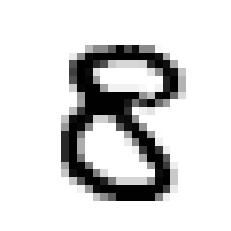

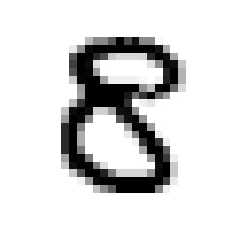

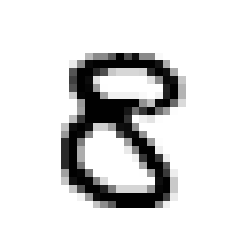

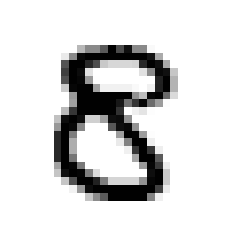

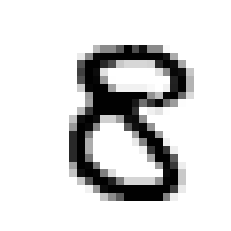

In [35]:
def plot_digit(image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    ax.axis('off')


def move_image(image, direction):
    if direction == 'up':
        zeros = np.zeros((1, image.shape[0]))
        return np.vstack([image[1:, :], zeros])
    elif direction == 'down':
        zeros = np.zeros((1, image.shape[0]))
        return np.vstack([zeros, image[:-1, :]])
    elif direction == 'left':
        zeros = np.zeros((image.shape[0], 1))
        return np.hstack([image[:, 1:], zeros])
    elif direction == 'right':
        zeros = np.zeros((image.shape[0], 1))
        return np.hstack([zeros, image[:, :-1]])


random_index = 1489
common_image = X_train[random_index].reshape(28, 28)
# print('common')
plot_digit(common_image)
for dir in ['up', 'down', 'left', 'right']:
    # print(dir)
    plot_digit(move_image(common_image, dir))

(60000, 784)


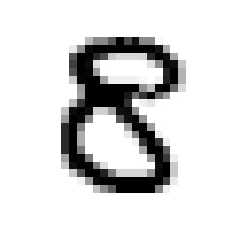

In [39]:
plot_digit(move_image(common_image, 'up').ravel().reshape(28, 28))
print(X_train.shape)

In [ ]:
X_train_expanded = np.concatenate([X_tarin, ])
# TODO apply function for numpy array, make more effective


In [21]:
best_cls.fit(X_train, y_train)
y_predict = best_cls.predict(X_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])